# Spread Spectrum Watermarking

Spread Spectrum Watermarking is a robust, **NON-BLIND** watermarking technique distributing the watermark's signal over a wide range of frequencies (like in spread spectrum communication techniques).

This method makes the watermark harder to detect, remove, or interfere with, which is especially useful for copyright protection, content authentication, and other security applications.

### Key Concepts:

1. Spread watermark on a broad frequency band (much larger than the one needed to embed the entire watermark);

2. Very Robust and Resilient to different types of attacks;

3. Watermark embedded spreading its energy across the frequency spectrum;

4. During the embedding the watermark can be modulated (or weighted), using $\alpha$ to improve its invisibility.

### Embedding algorithm

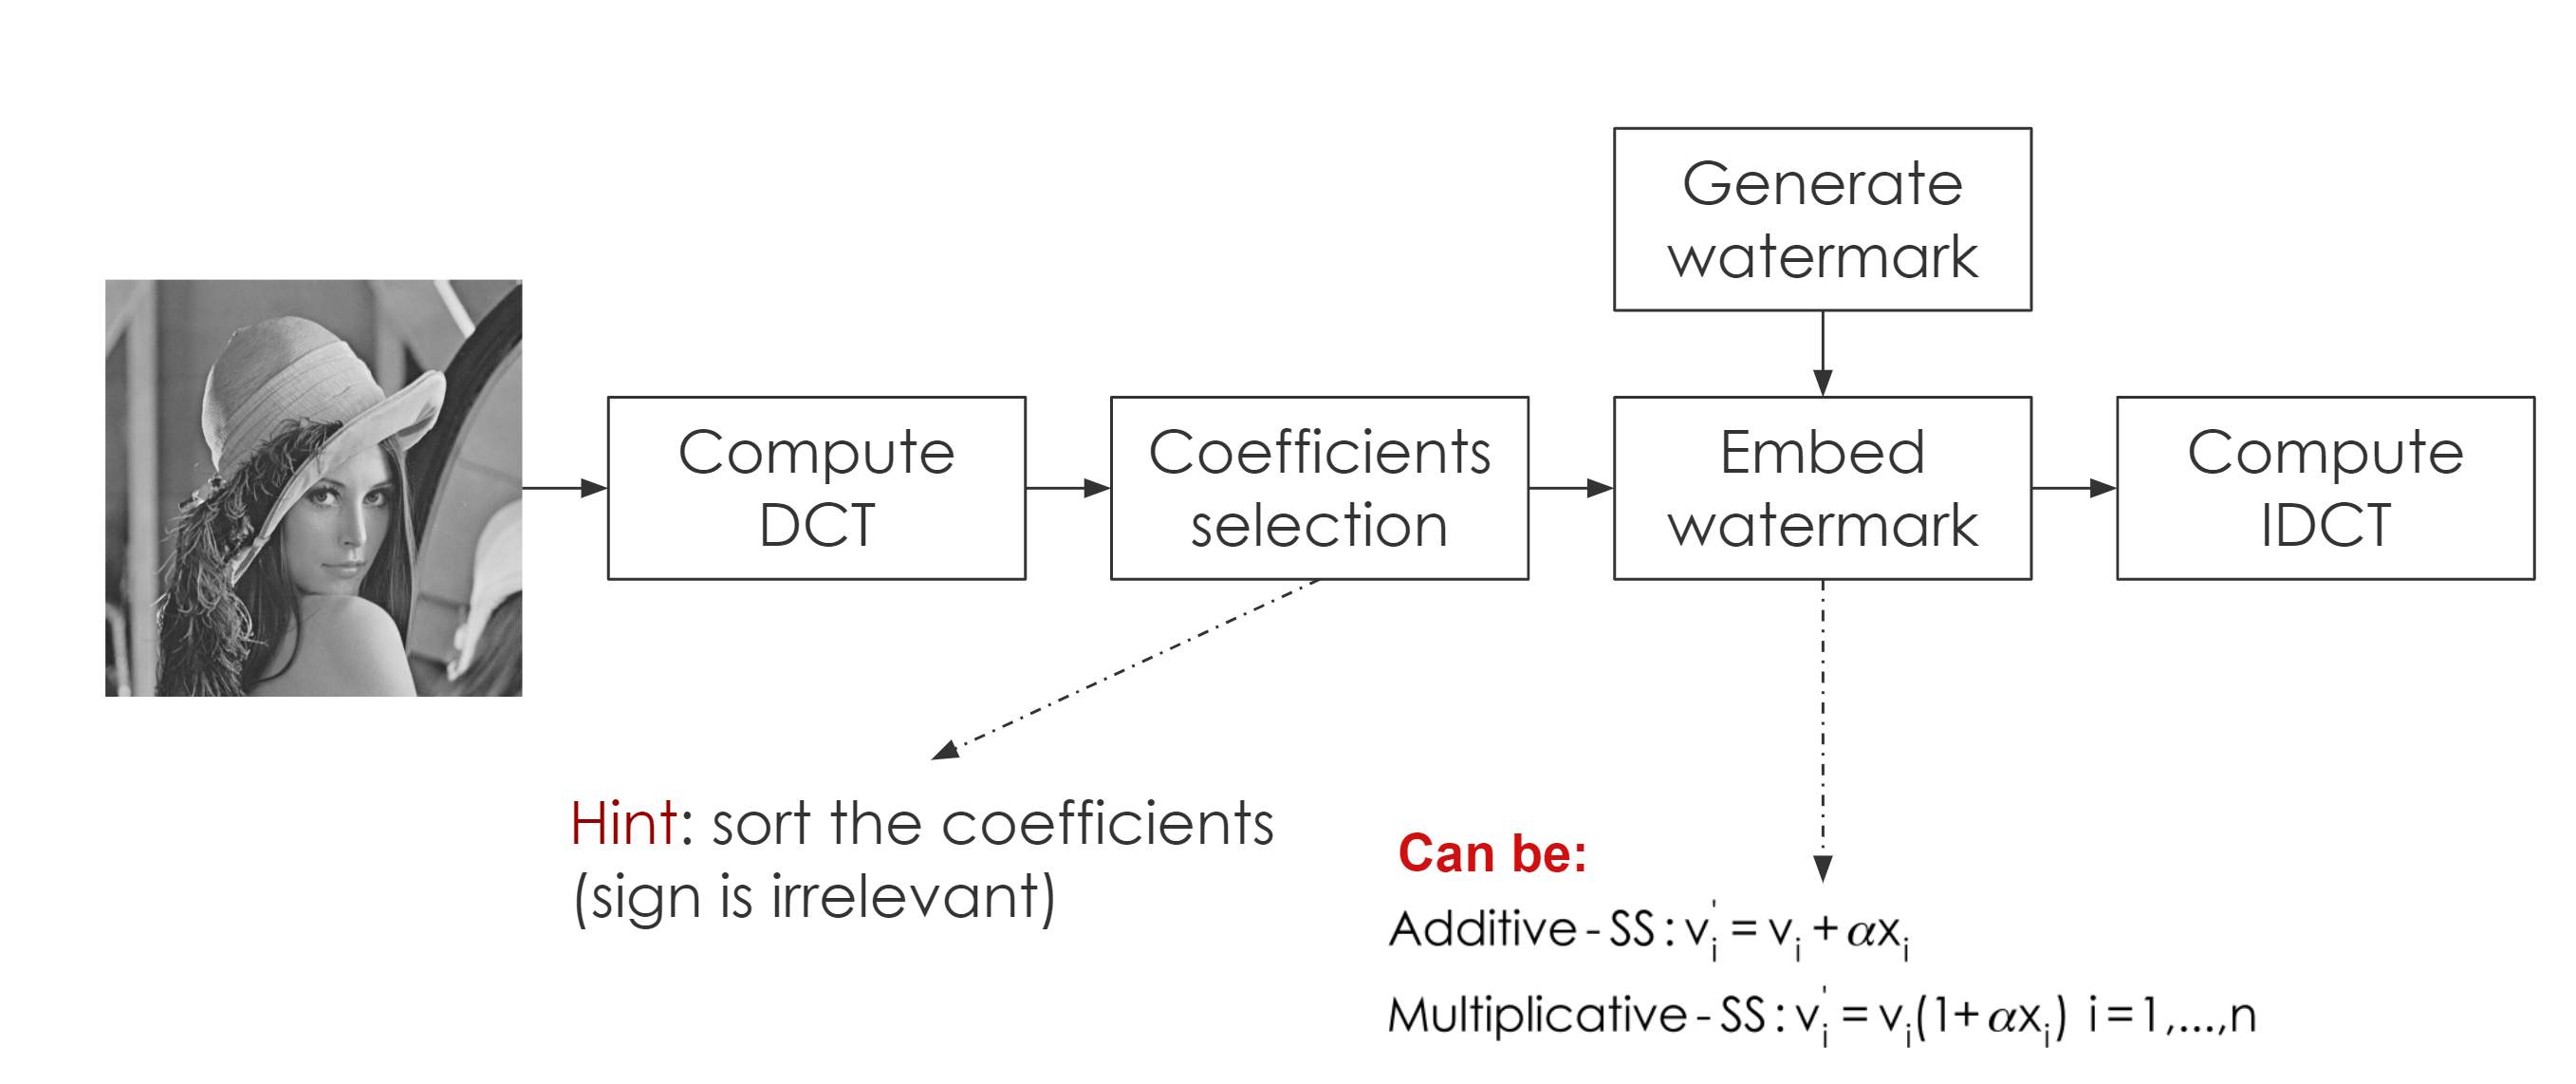

In [1]:
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.1
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

## Embedding

In [2]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))

    return mark, watermarked


mark, watermarked = embedding(image, N, alpha, v)
cv2.imwrite('watermarked.bmp', watermarked)

True

## Quality

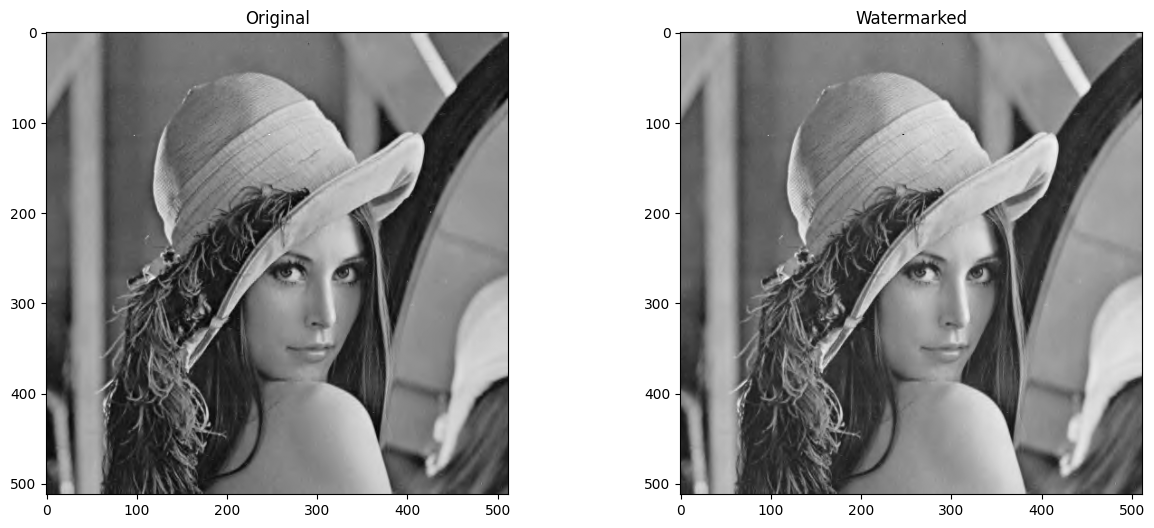

PSNR: 37.65dB
wPSNR: 44.20dB


In [3]:
def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0

  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  csf = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(csf,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

# Plot the two images side by side
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

# Compute quality
psnr = cv2.PSNR(image, watermarked)
print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)

## Detection

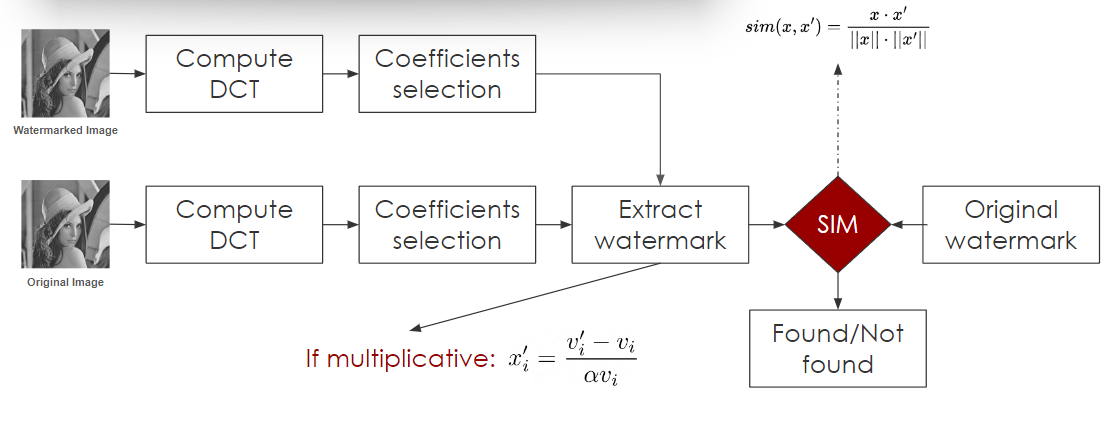
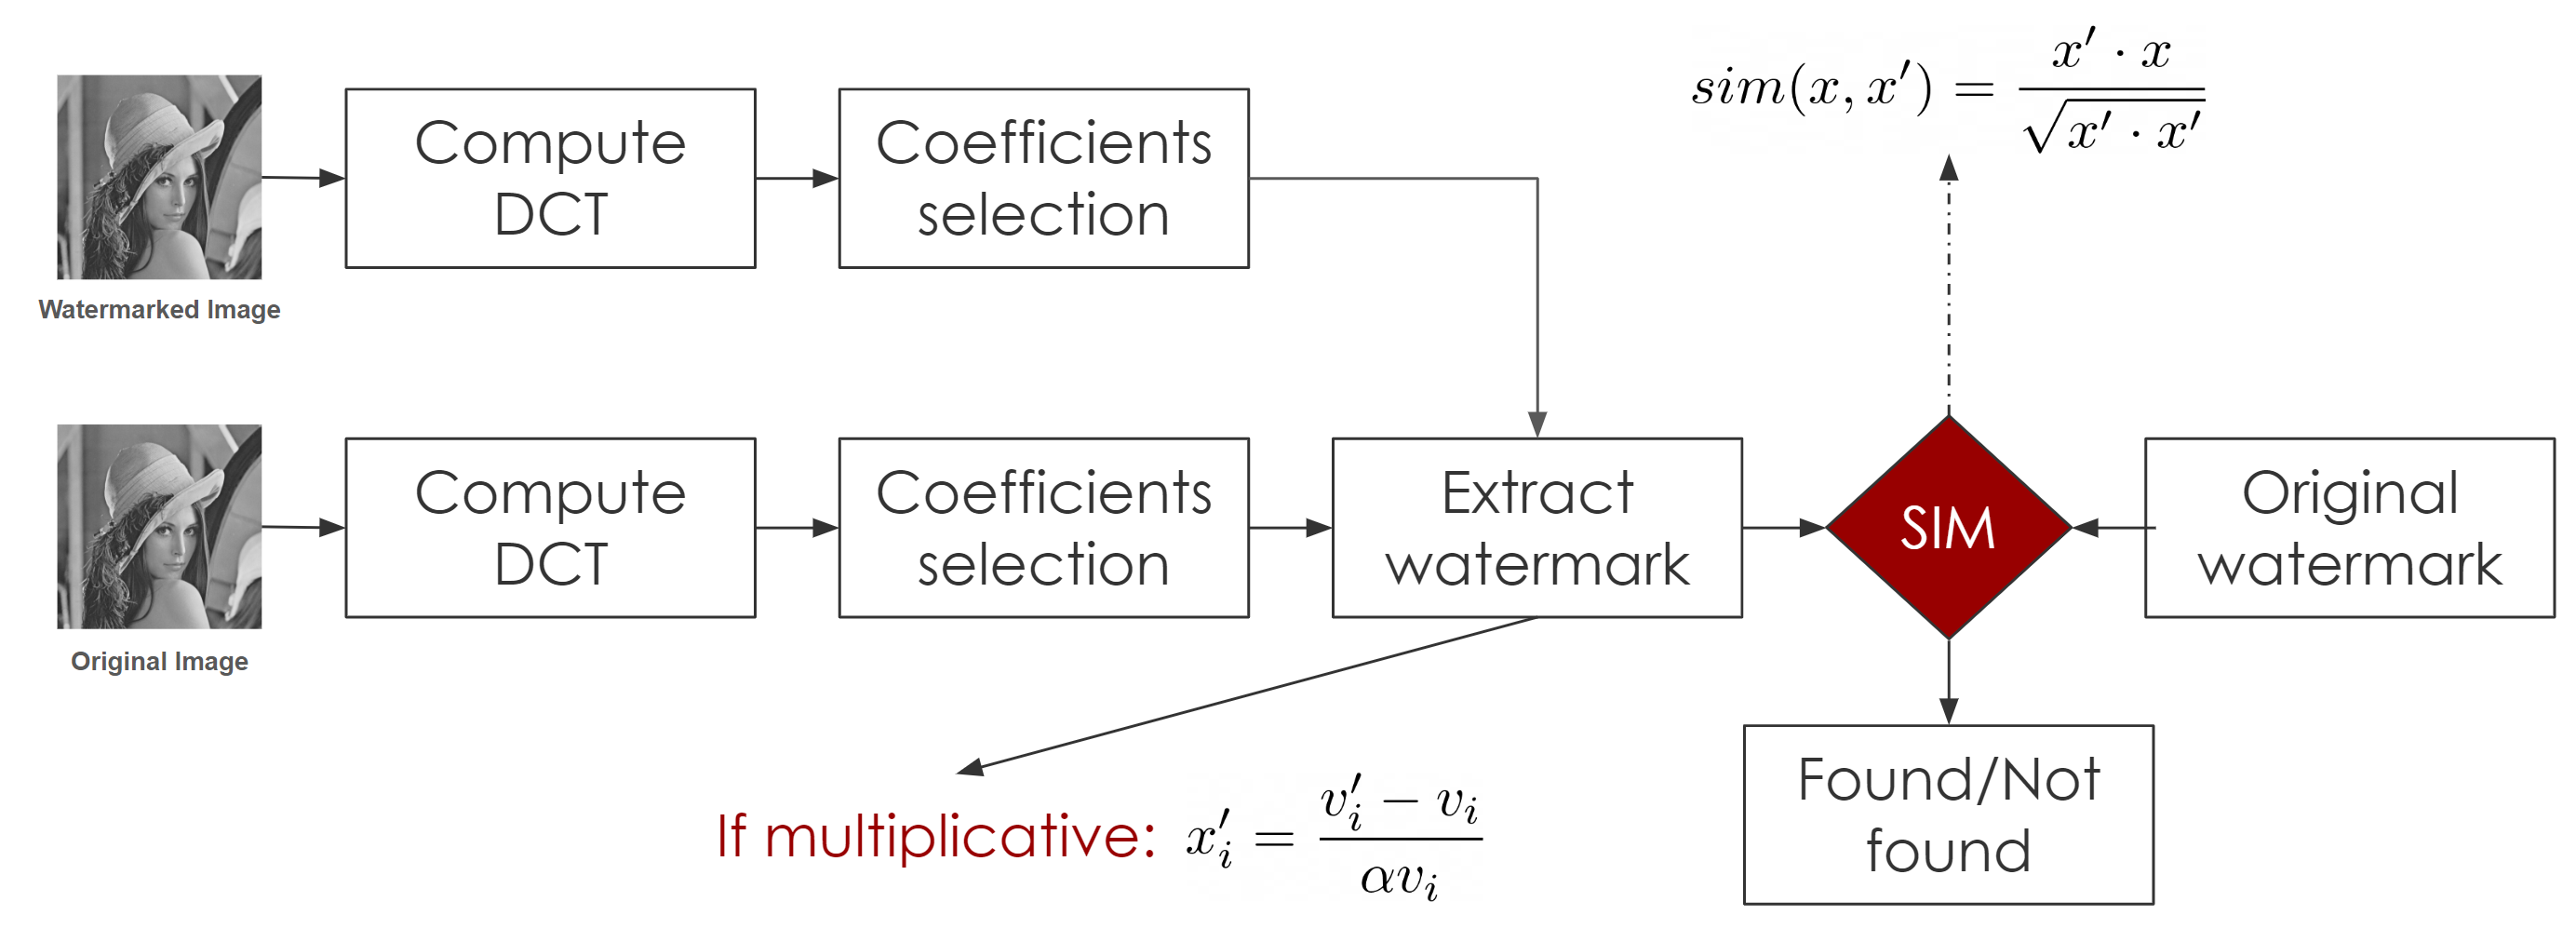
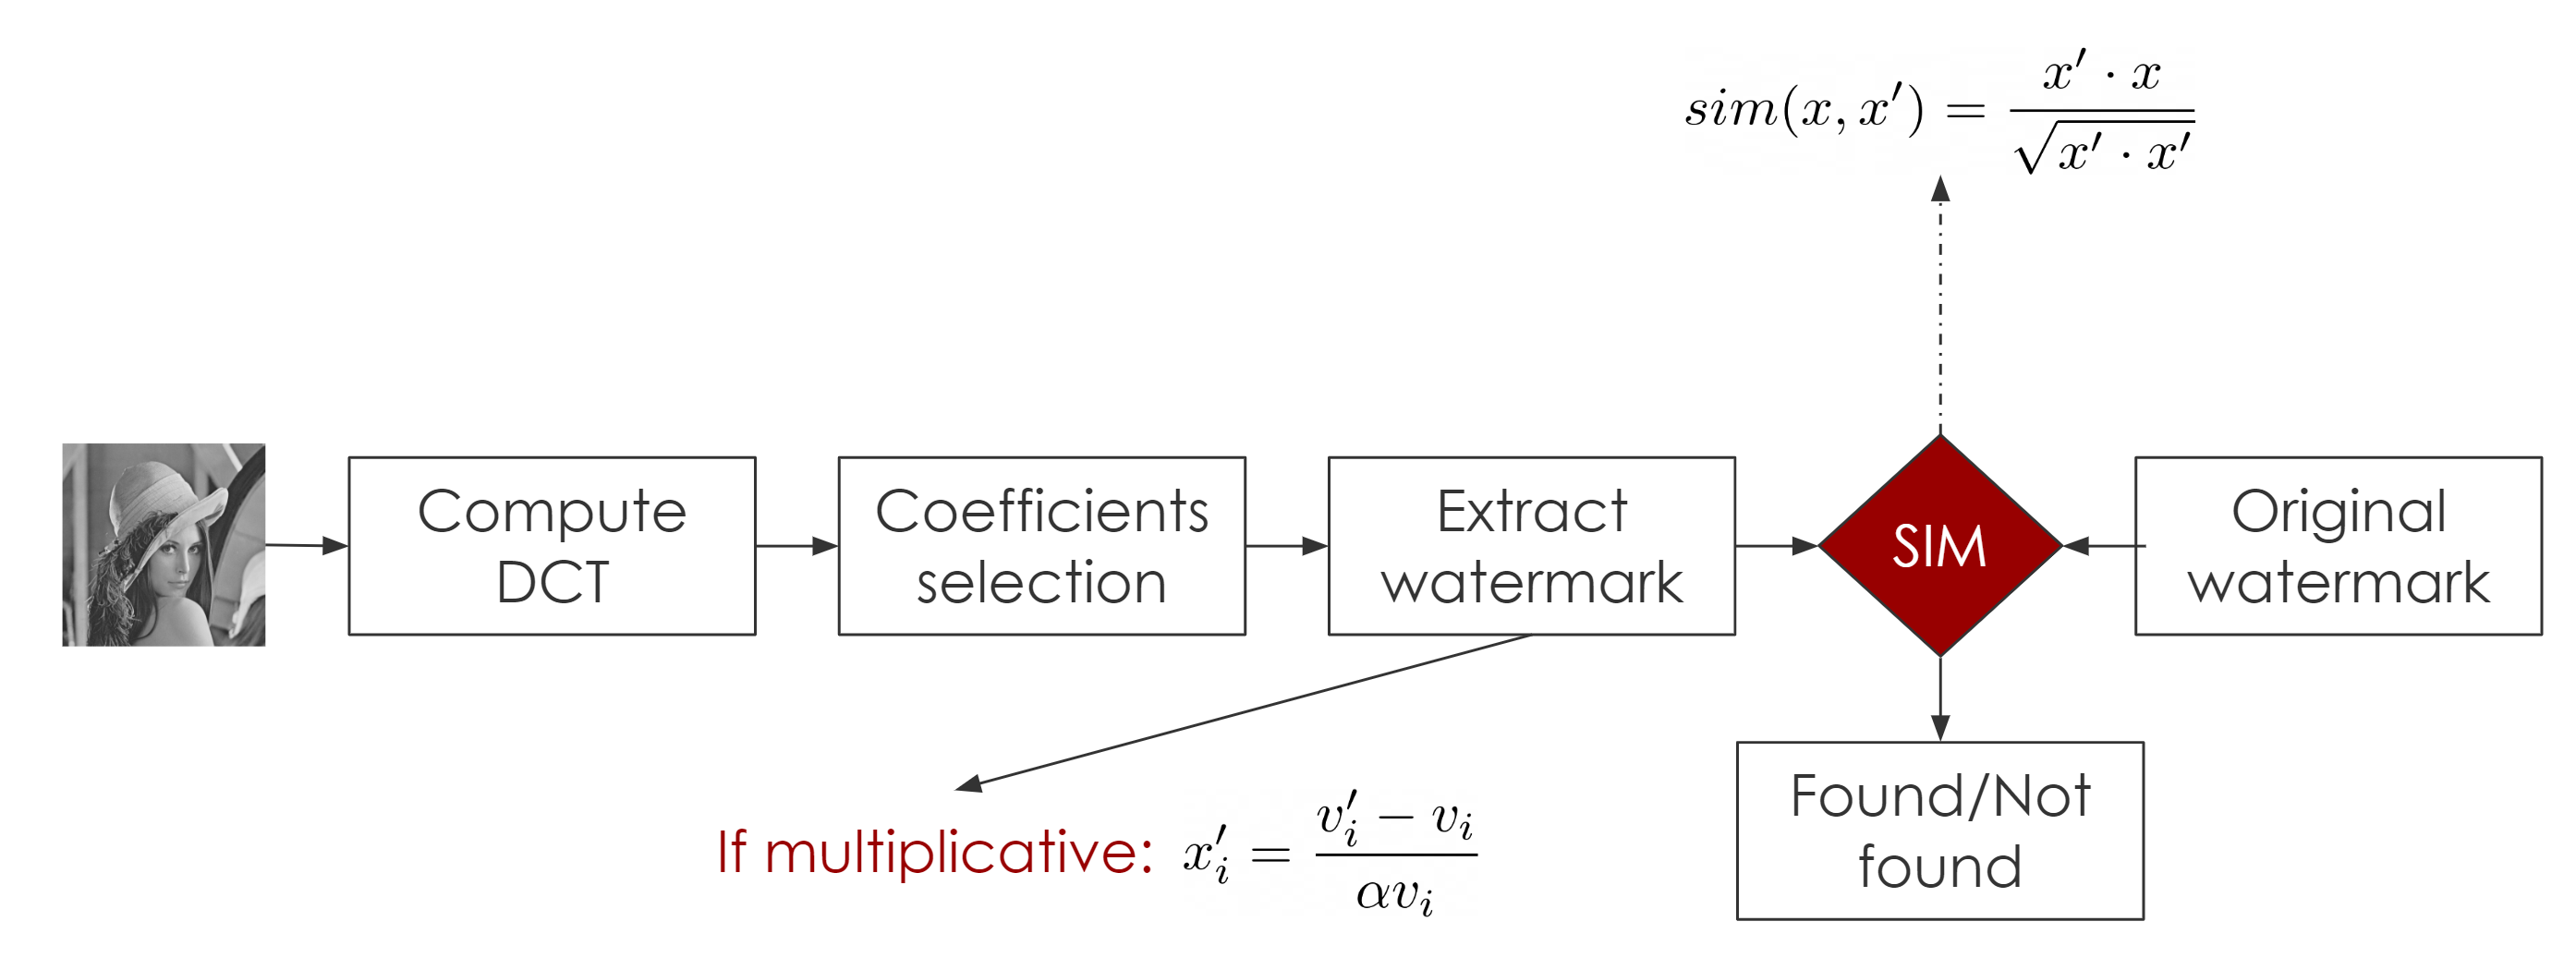
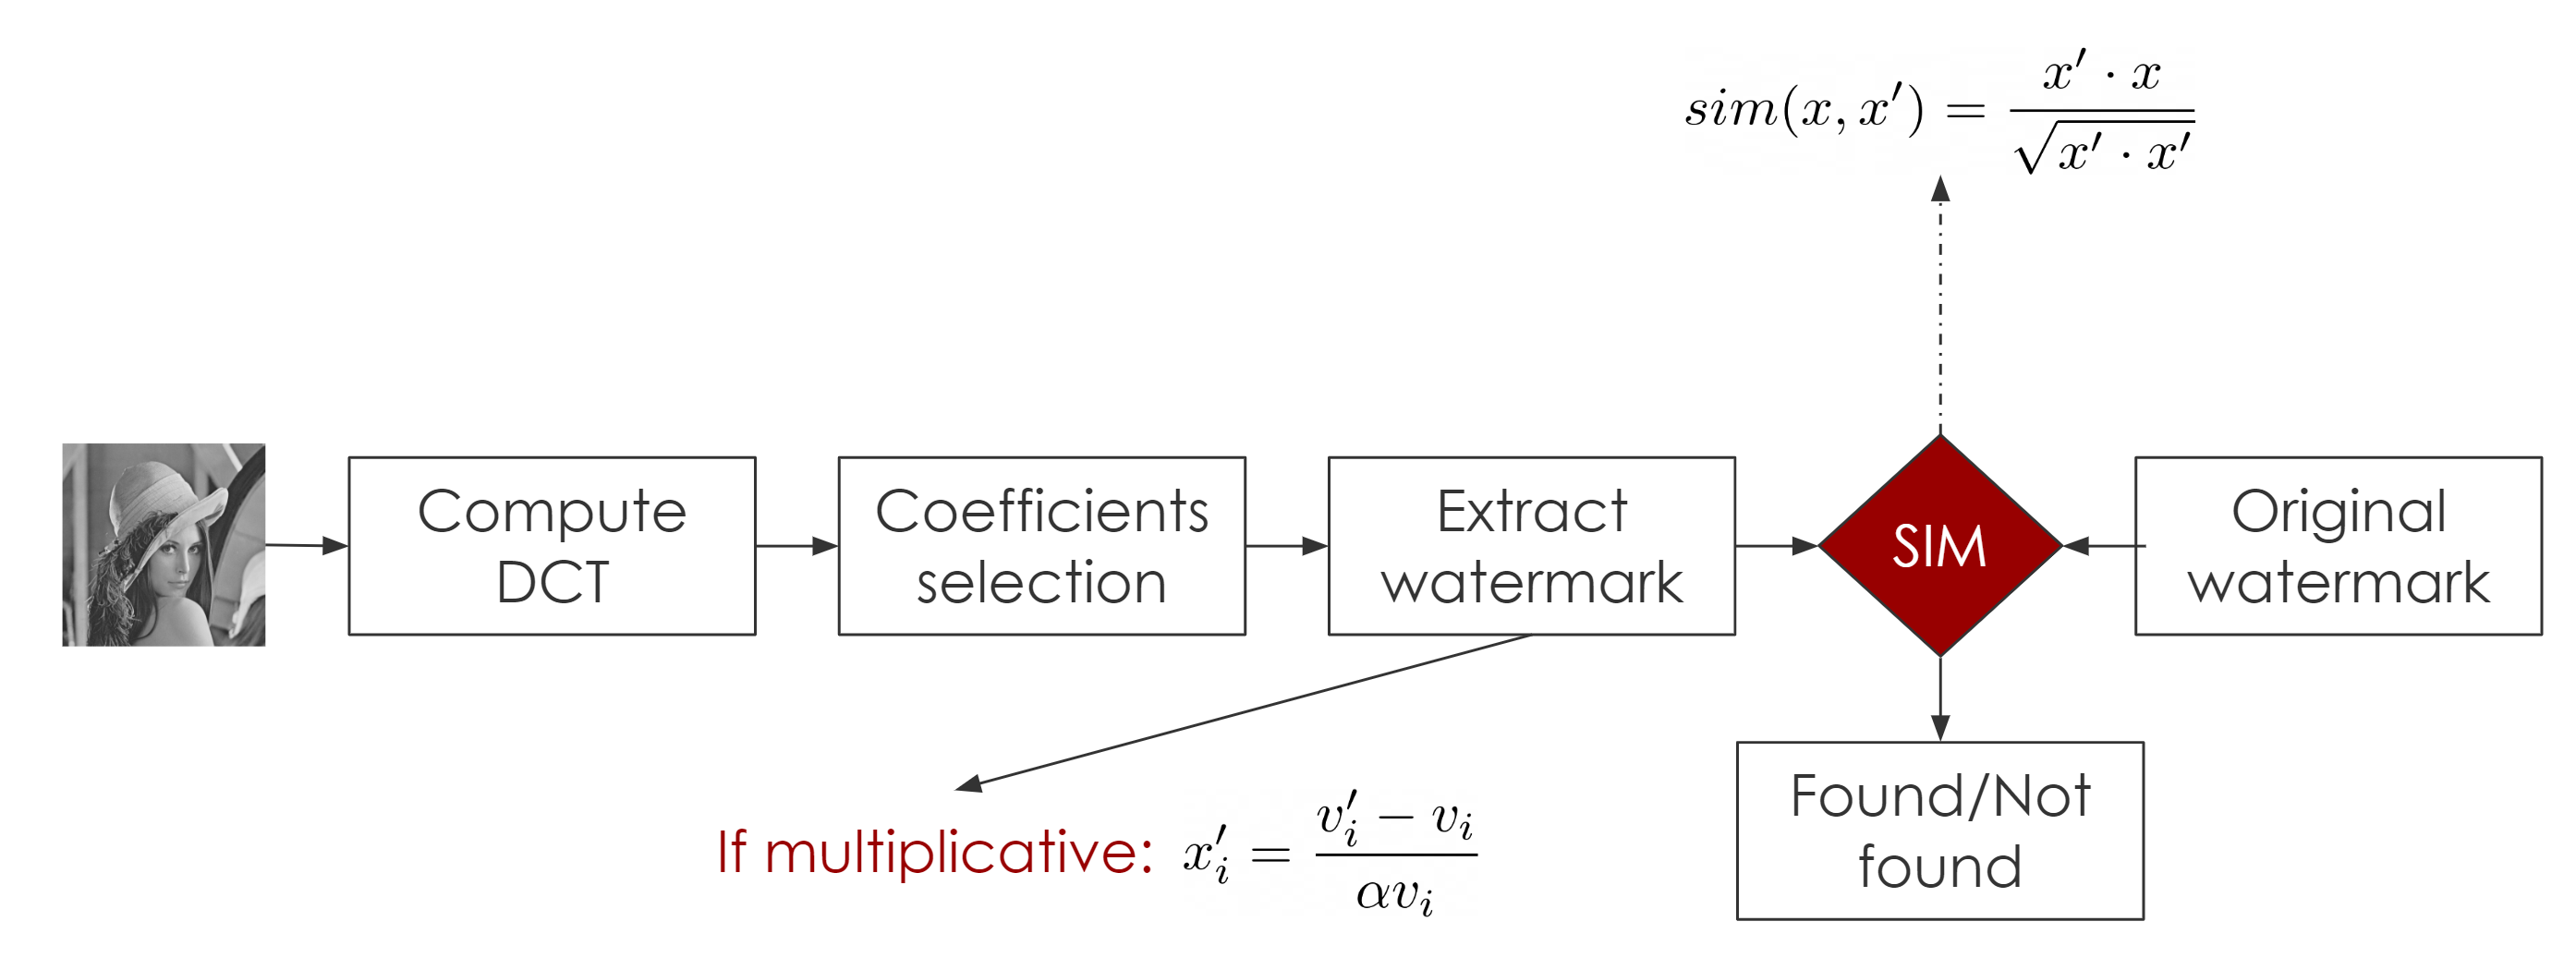

In [4]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

w_ex = detection(image, watermarked, alpha, N, v)

## Deciding whether the mark is present or not using a threshold

In [5]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

threshold:  0.7155977263270926
Mark has been found. SIM = 0.997930
